# 📦 Delivery Time Forecasting

## 🧩 Problem Definition

The goal of this project is to build a predictive model capable of estimating delivery time based on operational, environmental, and contextual variables. The model must achieve **low Mean Squared Error (MSE)** and **high R² score** on the test set. Additionally, it should be designed for **continuous improvement** as new data becomes available and must be ready to **serve predictions via API**.

### 🛠️ Input Features

- **Distance (KM):** Numeric value representing delivery distance.
- **Weather Conditions:** Categorical/encoded value representing conditions such as sunny, rainy, storm, etc.
- **Traffic Level:** Categorical or ordinal variable representing traffic intensity.
- **Time of Day:** Possible formats include hour-of-day, time slot, or cyclical encoding.
- **Courier Experience:** Numeric or categorical indication of the courier’s level of expertise.
- **Vehicle Type:** Categorical variable (bike, motorcycle, car, etc.).

### 🎯 Objective

Build a model that:

1. Minimizes **Mean Squared Error (MSE)**   
2. Maximizes **R² Score**  
3. Can be **incrementally improved** with new data  
4. Can be integrated into a **REST API** for production use  

---

## 🚀 Project Workflow

### 1. **Data Loading**
- Import the dataset from local storage, Google Drive, or Kaggle API.
- Validate column types and parse timestamps if included.

### 2. **Exploratory Data Analysis (EDA)**
- Check missing values  
- Analyze feature distributions  
- Identify outliers  
- Study correlations  

### 3. **Feature Engineering**
- Encode categorical variables  
- Normalize/standardize numerical variables  
- Create derived features (e.g., cyclical encoding for time)  
- Handle skewness and outliers  

### 4. **Model Training**
Possible candidates:
- Linear Regression  
- Random Forest Regressor  
- Gradient Boosting (XGBoost, LightGBM, CatBoost)  
- Neural Networks (if dataset is large enough)

### 5. **Model Evaluation**
Compute:
- **MSE**
- **RMSE**
- **R² Score**
- **Residual analysis**

Use cross-validation for more robust performance estimates.




# Exploratory Data Analysis

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("Food_Delivery_Times.csv")
df.drop(["Order_ID", "Preparation_Time_min"], axis=1, inplace=True)
df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,1.0,43
1,16.42,Clear,Medium,Evening,Bike,2.0,84
2,9.52,Foggy,Low,Night,Scooter,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,1.0,37
4,19.03,Clear,Low,Morning,Bike,5.0,68


In [ ]:
# First we check for missing values:

df.isnull().sum()

,0
Distance_km,0
Weather,30
Traffic_Level,30
Time_of_Day,30
Vehicle_Type,0
Courier_Experience_yrs,30
Delivery_Time_min,0


In [ ]:
# Note that we can substitute the missing values for the modes of each column

df['Weather'].fillna(df['Weather'].mode()[0], inplace=True)
df['Traffic_Level'].fillna(df['Traffic_Level'].mode()[0], inplace=True)
df['Time_of_Day'].fillna(df['Time_of_Day'].mode()[0], inplace=True)
df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].mode()[0])

/tmp/ipython-input-1694296086.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Weather'].fillna(df['Weather'].mode()[0], inplace=True)
/tmp/ipython-input-1694296086.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

,Courier_Experience_yrs
0,1.0
1,2.0
2,1.0
3,1.0
4,5.0
...,...
995,3.0
996,9.0
997,2.0
998,0.0


<Axes: xlabel='Delivery_Time_min'>

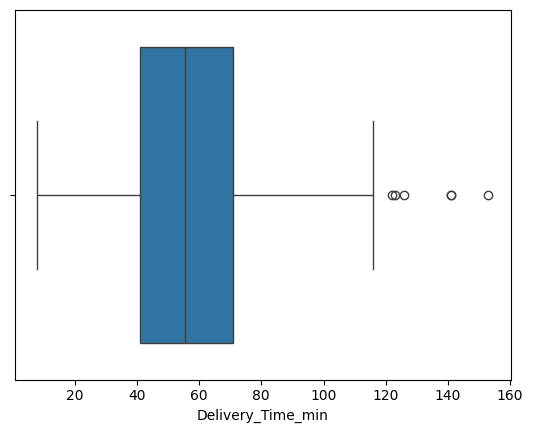

In [ ]:
# Now we can do some visualizations for consistency:

sns.boxplot(x=df['Delivery_Time_min'])

<Axes: xlabel='Delivery_Time_min', ylabel='Count'>

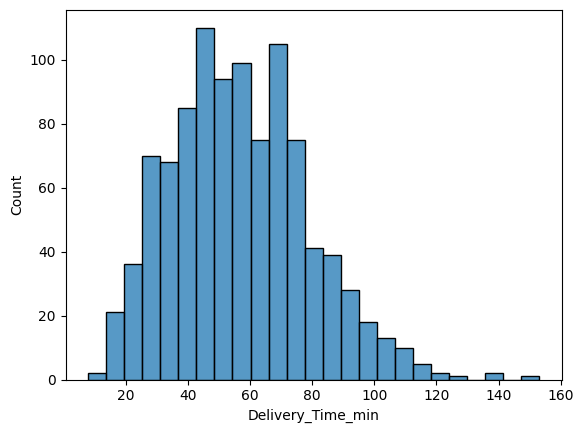

In [ ]:
# verificar as distancias e os tempos de entrega com histogramas

sns.histplot(df['Delivery_Time_min'])

In [ ]:
# lets check for skewness:

df['Delivery_Time_min'].skew()

np.float64(0.5072511816152696)

<Axes: xlabel='Distance_km', ylabel='Count'>

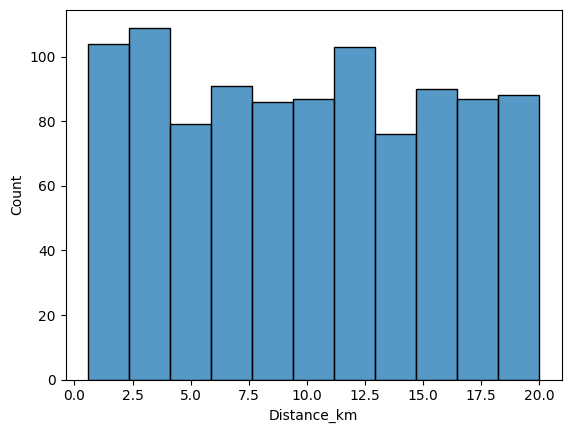

In [ ]:
# Since the delivery time is moderately assimetric, we can proceed with our analysis
# without further treatment

sns.histplot(df['Distance_km'])

<Axes: >

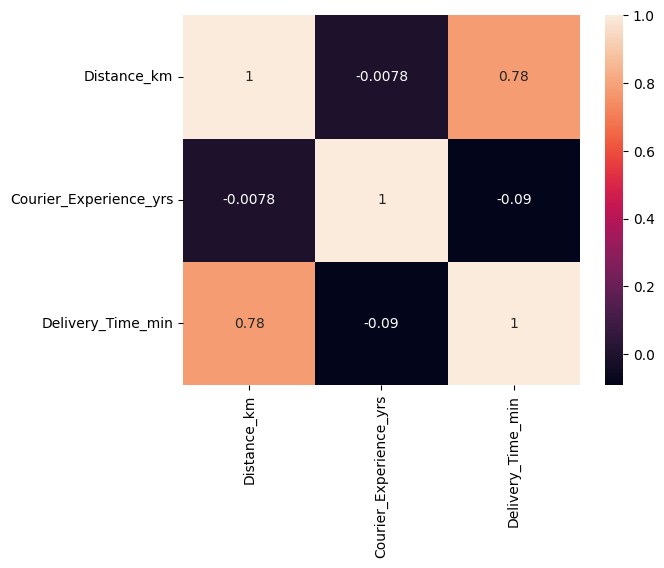

In [ ]:
# note that we have a few outliers, but it shouldn't do any harm in this case (we are dealing with 1000 rows)
# Now we check for correlations in numeric columns

num_columns = df.select_dtypes(include=[np.number]).columns

sns.heatmap(df[num_columns].corr(), annot=True)

In [ ]:
# we can see that there is a natural correlation of delivery time with respect to distance
# but experience doesnt have to do with delivery time so we are dropping this column out of the
# features

df.drop("Courier_Experience_yrs", axis=1, inplace=True)

# Feature Engineering

In [ ]:
# lets encode all our categorical variables with one-hot encoders in order to capture independent
# tendencies per value

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

encoder = OneHotEncoder(sparse_output=False)
encoded_columns = pd.DataFrame(encoder.fit_transform(df[["Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type"]]))
encoded_columns.columns = encoder.get_feature_names_out()
df = pd.concat([df, encoded_columns], axis=1)
df.drop(["Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type"], axis=1, inplace=True)

In [ ]:
# Let's use the standard scaler on numeric variables as we assume simmetrical distributions on
# the data:

scaler = StandardScaler()
num_columns = ["Distance_km", "Delivery_Time_min"]
df[num_columns] = scaler.fit_transform(df[num_columns])

# Model Training

In [ ]:
# let's train two models:

# 1) Linear regression: for baseline comparison
# 2) Random Forest Regression: for more robust methodology

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# First let's separate the data in training and test sets

X_train, X_test, y_train, y_test = train_test_split(df.drop("Delivery_Time_min", axis=1), df["Delivery_Time_min"], test_size=0.2, random_state=42)

In [ ]:
# ajuste de modelos

lr = LinearRegression()
lr.fit(X_train, y_train)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

# Model Evaluation

In [ ]:
# Now it's time for model evaluation

from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y_test, lr.predict(X_test)), r2_score(y_test, lr.predict(X_test))

# thus we have quite a good result but with room for improvements

(0.25905618657658913, 0.7187437678931594)